In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/Users/pragathi.vetrivelmurugan/Desktop/TSAI/TSAI-Assignment-6/tsai_env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


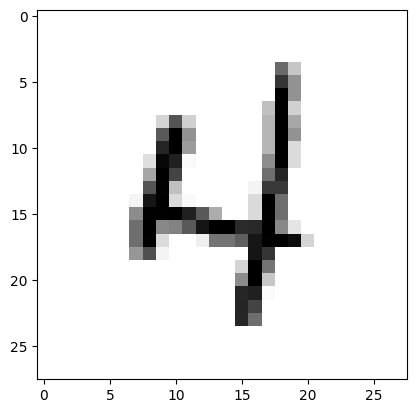

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


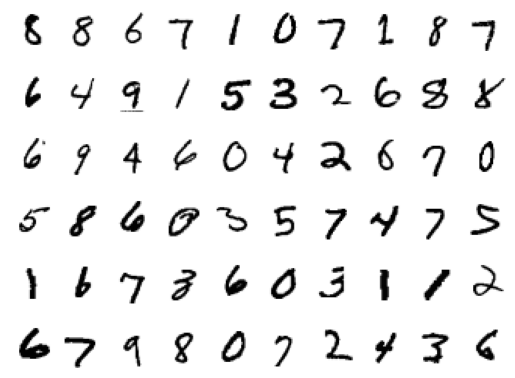

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### Model Definition

In [102]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=0),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )# 26X26X16
        self.convblock2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )# 24X24X32

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(8, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )#10X10X16

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(10, 10, 1, padding=0),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(10, 10, 10, padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        #x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(-1, 10)  # Flatten the tensor
        return F.log_softmax(x, dim=-1)

#### Model Summary

In [104]:
!pip install torchsummary tqdm
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             296
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 12, 12]             144
       BatchNorm2d-9           [-1, 16, 12, 12]              32
             ReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]           1,450
      BatchNorm2d-12           [-1, 10, 10, 10]     

#### Model Training and Testing

In [105]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [106]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.011363556608557701 Batch_id=937 Accuracy=95.62: 100%|█| 938/938 [00:25<00



Test set: Average loss: 0.0650, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.03748512640595436 Batch_id=937 Accuracy=98.31: 100%|█| 938/938 [00:26<00:



Test set: Average loss: 0.0462, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.006760403048247099 Batch_id=937 Accuracy=98.69: 100%|█| 938/938 [00:24<00



Test set: Average loss: 0.0376, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.000871172349434346 Batch_id=937 Accuracy=98.93: 100%|█| 938/938 [00:33<00



Test set: Average loss: 0.0364, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.07656792551279068 Batch_id=937 Accuracy=99.12: 100%|█| 938/938 [00:31<00:



Test set: Average loss: 0.0317, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.0008656036807224154 Batch_id=937 Accuracy=99.22: 100%|█| 938/938 [00:34<0



Test set: Average loss: 0.0398, Accuracy: 9860/10000 (98.60%)

EPOCH: 6


Loss=0.0012317205546423793 Batch_id=937 Accuracy=99.29: 100%|█| 938/938 [00:31<0



Test set: Average loss: 0.0315, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.0032352216076105833 Batch_id=937 Accuracy=99.41: 100%|█| 938/938 [00:32<0



Test set: Average loss: 0.0329, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.017142895609140396 Batch_id=937 Accuracy=99.42: 100%|█| 938/938 [00:32<00



Test set: Average loss: 0.0332, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


Loss=0.1223936378955841 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [00:31<00:0



Test set: Average loss: 0.0375, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.00138790940400213 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [00:35<00:



Test set: Average loss: 0.0312, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.0007469068514183164 Batch_id=937 Accuracy=99.57: 100%|█| 938/938 [00:30<0



Test set: Average loss: 0.0306, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.00376885081641376 Batch_id=937 Accuracy=99.67: 100%|█| 938/938 [00:32<00:



Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.0022888812236487865 Batch_id=937 Accuracy=99.67: 100%|█| 938/938 [00:32<0



Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.00011366191029082984 Batch_id=937 Accuracy=99.69: 100%|█| 938/938 [00:32<



Test set: Average loss: 0.0406, Accuracy: 9882/10000 (98.82%)



Selected random misclassified image with true label: 9
Image shape: torch.Size([1, 1, 28, 28])
convblock1 output shape: torch.Size([1, 4, 26, 26])
convblock2 output shape: torch.Size([1, 8, 24, 24])
pool1 output shape: torch.Size([1, 8, 12, 12])
convblock3 output shape: torch.Size([1, 16, 12, 12])
convblock4 output shape: torch.Size([1, 10, 10, 10])
convblock6 output shape: torch.Size([1, 10, 1, 1])
logits output shape: torch.Size([1, 10])
Predicted label: 7


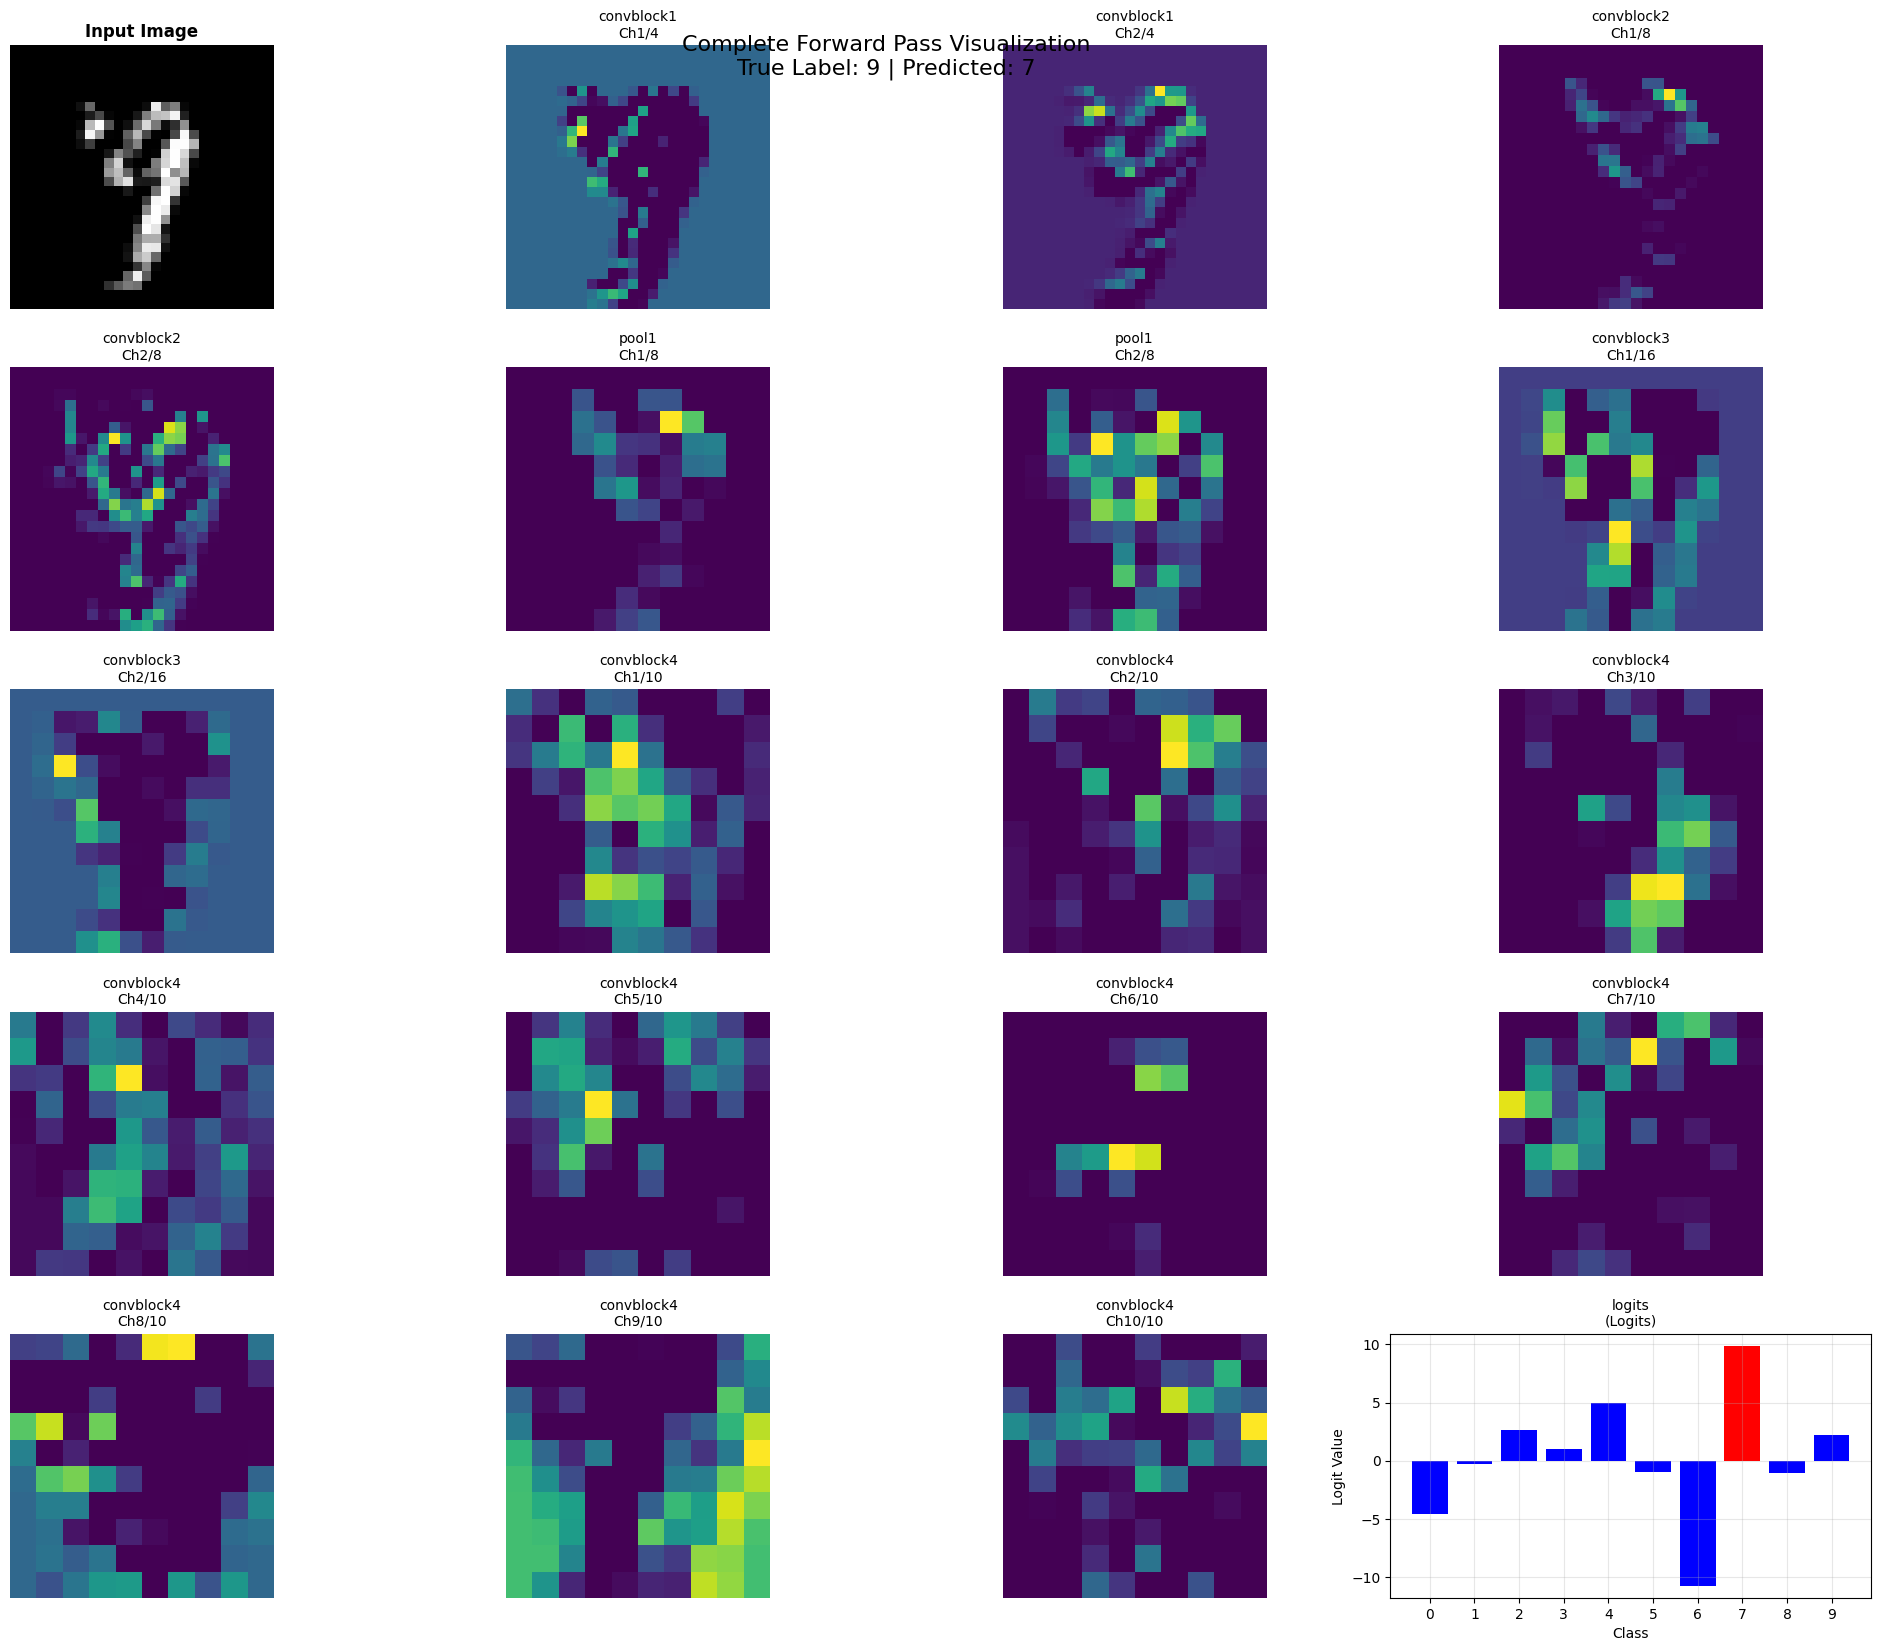


DETAILED LAYER OUTPUT STATISTICS

convblock1 (Conv Layer):
  Shape: torch.Size([1, 4, 26, 26])
  Mean activation: 0.4290
  Std activation: 0.4232
  Min: 0.0000, Max: 3.4466
  Sparsity (% zeros): 11.95%

convblock2 (Conv Layer):
  Shape: torch.Size([1, 8, 24, 24])
  Mean activation: 0.2760
  Std activation: 0.4916
  Min: 0.0000, Max: 4.8401
  Sparsity (% zeros): 51.65%

pool1 (Conv Layer):
  Shape: torch.Size([1, 8, 12, 12])
  Mean activation: 0.4704
  Std activation: 0.6948
  Min: 0.0000, Max: 4.8401
  Sparsity (% zeros): 39.24%

convblock3 (Conv Layer):
  Shape: torch.Size([1, 16, 12, 12])
  Mean activation: 0.3377
  Std activation: 0.4729
  Min: 0.0000, Max: 4.4011
  Sparsity (% zeros): 47.14%

convblock4 (Conv Layer):
  Shape: torch.Size([1, 10, 10, 10])
  Mean activation: 0.6494
  Std activation: 0.9726
  Min: 0.0000, Max: 5.3285
  Sparsity (% zeros): 49.30%

convblock6 (Conv Layer):
  Shape: torch.Size([1, 10, 1, 1])
  Mean activation: 0.2967
  Std activation: 5.2277
  Min: -10.7

In [107]:
# Visualize the complete forward pass through all layers
def visualize_complete_forward_pass(model, device, test_loader):
    """
    Choose a random misclassified image from test set and visualize outputs through all layers
    """
    model.eval()
    
    # Find a random misclassified sample
    sample_image = None
    true_label = None
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get indices of misclassified samples
                incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]
                
                # Choose a random one
                import random
                random_idx = random.choice(incorrect_indices.cpu().numpy())
                
                sample_image = data[random_idx:random_idx+1]
                true_label = target[random_idx].cpu().item()
                break
    
    if sample_image is None:
        print("No misclassified samples found in the test data!")
        return
    
    print(f"Selected random misclassified image with true label: {true_label}")
    print(f"Image shape: {sample_image.shape}")
    
    # Store outputs at each layer
    layer_outputs = {}
    layer_names = []
    
    # Manual forward pass to capture intermediate outputs
    with torch.no_grad():
        # Layer 1: convblock1
        x = model.convblock1(sample_image)
        layer_outputs['convblock1'] = x.cpu()
        layer_names.append('convblock1')
        print(f"convblock1 output shape: {x.shape}")
        
        # Layer 2: convblock2
        x = model.convblock2(x)
        layer_outputs['convblock2'] = x.cpu()
        layer_names.append('convblock2')
        print(f"convblock2 output shape: {x.shape}")
        
        # Layer 3: pool1
        x = model.pool1(x)
        layer_outputs['pool1'] = x.cpu()
        layer_names.append('pool1')
        print(f"pool1 output shape: {x.shape}")
        
        # Layer 4: convblock3
        x = model.convblock3(x)
        layer_outputs['convblock3'] = x.cpu()
        layer_names.append('convblock3')
        print(f"convblock3 output shape: {x.shape}")
        
        # Layer 5: convblock4
        x = model.convblock4(x)
        layer_outputs['convblock4'] = x.cpu()
        layer_names.append('convblock4')
        print(f"convblock4 output shape: {x.shape}")
        
        # Layer 6: convblock6
        x = model.convblock6(x)
        layer_outputs['convblock6'] = x.cpu()
        layer_names.append('convblock6')
        print(f"convblock6 output shape: {x.shape}")
        
        # Flatten and final output (logits)
        x_flat = x.view(-1, 10)
        layer_outputs['logits'] = x_flat.cpu()
        layer_names.append('logits')
        print(f"logits output shape: {x_flat.shape}")
        
        # Get prediction
        pred_label = x_flat.argmax(dim=1).item()
        print(f"Predicted label: {pred_label}")
    
    # Create visualization
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f'Complete Forward Pass Visualization\nTrue Label: {true_label} | Predicted: {pred_label}', 
                 fontsize=16, y=0.95)
    
    # Original image
    plt.subplot(6, 4, 1)
    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title('Input Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    subplot_idx = 2
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.squeeze().numpy()
        
        if layer_name == 'logits':
            # For final logits, show the 10 class logits as a bar chart
            plt.subplot(6, 4, subplot_idx)
            plt.bar(range(10), output_np, color=['red' if i == pred_label else 'blue' for i in range(10)])
            plt.title(f'{layer_name}\n(Logits)', fontsize=10)
            plt.xlabel('Class')
            plt.ylabel('Logit Value')
            plt.xticks(range(10))
            plt.grid(True, alpha=0.3)
            
        elif layer_name == 'convblock6':
            # Special handling for convblock6: show all 10 channels as a bar chart
            plt.subplot(6, 4, subplot_idx)
            conv6_values = output_np  # Shape: (10,)
            plt.bar(range(10), conv6_values, color='purple')
            plt.title(f'{layer_name}\nAll 10 Channels', fontsize=10)
            plt.xlabel('Channel')
            plt.ylabel('Activation Value')
            plt.xticks(range(10))
            plt.grid(True, alpha=0.3)
            
        elif len(output.shape) == 4:  # Convolutional layers (batch, channels, height, width)
            batch_size, num_channels, height, width = output.shape
            
            # Special case for convblock4: show all 10 channels
            if layer_name == 'convblock4':
                channels_to_show = num_channels  # 10
            else:
                channels_to_show = min(2, num_channels)
            
            for ch in range(channels_to_show):
                if subplot_idx > 24:  # If grid is full, create a new figure for remaining channels
                    plt.tight_layout()
                    plt.show()
                    fig = plt.figure(figsize=(20, 10))
                    fig.suptitle(f'Additional Feature Maps from {layer_name}', fontsize=16)
                    subplot_idx = 1
                    # Adjust grid for remaining channels, e.g., 2x5 for 10 channels
                    rows = (channels_to_show - ch + 4) // 5  # Approximate
                    cols = 5
                    plt.subplot(rows, cols, subplot_idx)
                
                plt.subplot(6, 4, subplot_idx)
                # Handle 1x1 feature maps by reshaping to 1x1 image
                feature_map = output_np[ch]
                if feature_map.ndim == 0:  # Scalar
                    feature_map = np.array([[feature_map]])
                plt.imshow(feature_map, cmap='viridis')
                plt.title(f'{layer_name}\nCh{ch+1}/{num_channels}', fontsize=10)
                plt.axis('off')
                subplot_idx += 1
                
                if subplot_idx > 24 and ch < channels_to_show - 1:
                    # If more channels, continue in new figure
                    continue
            
            # If we have more channels, skip to next layer position (but for convblock4 and convblock6, we show all)
            if channels_to_show < num_channels and layer_name not in ['convblock4', 'convblock6']:
                subplot_idx += (2 - channels_to_show)
        
        if subplot_idx > 24 and layer_name != layer_names[-1]:
            break
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each layer
    print("\n" + "="*60)
    print("DETAILED LAYER OUTPUT STATISTICS")
    print("="*60)
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.numpy()
        
        if layer_name == 'logits':
            print(f"\n{layer_name} (Output Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean: {output_np.mean():.4f}")
            print(f"  Std: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Predicted class: {pred_label} (logit: {output_np[0, pred_label]:.4f})")
        else:
            print(f"\n{layer_name} (Conv Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean activation: {output_np.mean():.4f}")
            print(f"  Std activation: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Sparsity (% zeros): {(output_np == 0).mean() * 100:.2f}%")

# Call the function to visualize complete forward pass
visualize_complete_forward_pass(model, device, test_loader)